In [50]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from pathlib import Path
from frlearn.classifiers import FRNN
from sklearn.model_selection import train_test_split
from frlearn.base import probabilities_from_scores
from sklearn.metrics import roc_auc_score


index = ["bkblk","bknwy","bkon8","bkona","bkspr","bkxbq","bkxcr","bkxwp","blxwp","bxqsq","cntxt","dsopp","dwipd",
 "hdchk","katri","mulch","qxmsq","r2ar8","reskd","reskr","rimmx","rkxwp","rxmsq","simpl","skach","skewr",
 "skrxp","spcop","stlmt","thrsk","wkcti","wkna8","wknck","wkovl","wkpos","wtoeg","win"]


data = pd.read_csv('/home/hamid/hamash_amir/research/rough_set/kr-vs-kp_csv.csv')
data.rename(columns = {'class':"win"}, inplace=True)
# data = pd.read_csv('/home/teslator/projects/rough_set/kr_vs_kp.csv')
# data.rename(columns = {'outcome':"win"}, inplace=True)

ns = pd.get_dummies(data[data.columns[:-1]], prefix=data.columns[:-1],drop_first=True, dtype=int)

ns_y = data['win'].copy()
Y = pd.get_dummies(ns_y,prefix='win',drop_first=True, dtype=int)


class Colony:
    


    dataframe: object = ns
    pheromone = np.ones((ns.shape[1], ns.shape[1]))
    traversed_nodes = np.zeros((ns.shape[1],ns.shape[1]))
    ant_route: list[int] = []
    alpha: float | int 
    beta: float | int 
    feature_choices: list[str] = dataframe.columns.tolist()
    feature1: str
    # log: list[str] = []
    log: dict = {}
    fg: list[str] = feature_choices.copy()
    acc_criteria: float
    rho: int | float
    delta = np.zeros((ns.shape[1],ns.shape[1]))
    colony_number: int = 0
    overall_ant_route: dict = {}
    
    # def __init__(self):
    #     self.ant_route = ant_route
    #     self.feature1 = feature1
    #     self.fg = fg
    
    
    @classmethod
    def set_stopping_criteria(cls, criteria):
        cls.acc_criteria = criteria
    
    @classmethod
    def set_rate_decay(cls, rate_decay):
        cls.rho = rate_decay
    
    @classmethod
    def add_generation(cls):
        cls.colony_number += 1

    
    @classmethod
    def get_log(cls):
        print(cls.log)
    
    @classmethod
    def reset_colony(cls):
        
        Colony.pheromone = np.ones((ns.shape[1], ns.shape[1]))
        Colony.traversed_nodes = np.zeros((ns.shape[1], ns.shape[1]))

        Colony.overall_ant_route = {}
        Colony.log = []
        Colony.fg = cls.feature_choices.copy()
    
    @classmethod
    def reset_fg(cls):
        """
        this function reset fg that is responsible for feature space possible for each ant
        and remove first choice of each ant from this space to avoid selecting same features 
        by next ant as beginner feature.AND AND AND
        
        remove first choice of each ant from fg to prevent next ants choosing that
        and each ant beging from different node as begining.
        """
        if cls.colony_number > 0:
            cls.fg = cls.feature_choices.copy()
        if cls.overall_ant_route:
            cls.fg = [y for y in cls.fg if y not in [cls.feature_choices[x[0]] for x in list(cls.overall_ant_route.values())]]
        # first_choice_of_each_ant = [first[0] for first in cls.overall_ant_route.values() if cls.overall_ant_route.values() != []]
        # first_choice_of_each_ant_list = [cls.feature_choices[i] for i in first_choice_of_each_ant]
        # cls.fg = [x for x in cls.fg if x not in first_choice_of_each_ant_list]
        
    @classmethod
    def initialization_alpha_beta(cls, alpha, beta):
        
        cls.alpha = alpha
        cls.beta = beta

    @classmethod
    def reset_ant_route(cls):
        cls.ant_route = []

    @classmethod
    def initialize_feature1(cls):
        ant_route = cls.ant_route
        if ant_route == []:
            cls.feature1 = np.random.choice(cls.feature_choices)
        else:
            cls.feature1 = cls.feature_choices[cls.ant_route[-1]]
    
    
    @classmethod
    def ant(cls):

        cls.initialization_alpha_beta(0.5, 0.5)
        cls.initialize_feature1()
        feature_1 = cls.feature1
        features = cls.dataframe.columns.tolist()
        if feature_1 in cls.fg:
            cls.fg.remove(feature_1)
        i = features.index(feature_1)
        if i not in cls.ant_route:
            cls.ant_route.append(i)

        feat1_dist_prob = {}
        for feature2 in cls.fg:
           
            pij = cls.__probability_transition_rule(cls.feature1, feature2)
      
            j = features.index(feature2)
            feat1_dist_prob[j] = pij

        
            # cls.log.append(f'feat1{features.index(cls.feature1)}' 
            #                f'--feat2{features.index(feature2)}--pij{float(pij)}--ant-route{cls.ant_route}'
            #                f'--fg{cls.fg}')
            # cls.log[f'{i}-{j}'] = pij

    
        # ant_next_target_index = [key for key, value in feat1_dist_prob.items() if value == max(feat1_dist_prob.values())][0]
        keys_with_max_value = [key for key,value in feat1_dist_prob.items() if value == max(feat1_dist_prob.values())]
        print(f'{[cls.fg.index(value) for value in cls.fg]}')
        print(f'keys_with_max_value : {keys_with_max_value}')
        print(f'feat1_dist_prob : {max(feat1_dist_prob.values())}')
        if keys_with_max_value:
            ant_next_target_index = keys_with_max_value[0]
            cls.traversed_nodes[i,ant_next_target_index] = 1
            # mitting criterion
            cls.ant_route.append(ant_next_target_index)
        fg_index = [key for key,value in feat1_dist_prob.items()]

    
    @classmethod
    def ants(
        cls, make_initialize: bool | None=None,
            number_of_ants_first_gen: int | None=None,
            number_of_ants_next_gen: int | None=None, 
            init_criteria: int | str | None=None,
            rate_decay: float | None=None, 
            phero_rate_decay: float | None=None):

        if cls.colony_number == 0 or make_initialize == True:
            cls.initialize_colony(
                number_of_ants_first_generation=number_of_ants_first_gen,
                                init_criteria=init_criteria)
            cls.generate_next_ants(
                number_of_ants_next_generation=number_of_ants_next_gen,
                rate_decay=rate_decay, phero_rate_decay=phero_rate_decay,
                criteria_func=cls.is_rough_set_criteria_met)
            

        
    @classmethod
    def change_pheromone(cls, q, rho):
        """
        After each generation of several ants or after each generation 
        it update pheromone matrix according to following formula:
         
        phromone[i,j](t+1) = (1-rho)*phromone[i,j](t) + Delta(ij)(t)
        
        rho is pheromone decay coefficient along time
        
        Delta(ij)(t) = |_| = Delta(ij)(t) = 
                       |_|   q/sigma(landa_prime(ant_route)/len(ant_route)) ,if traversed_node[i,j] = 1
                       |_| = 0                                            ,if traversed_node[i,j] = 0
        
        landa_prime is rough_set_measure           
        """
        cls.set_rate_decay(rho)
        minimum_ant_route_len = np.min([len(x) for x in list(cls.overall_ant_route.values())])
        for i in range(cls.delta.shape[0]):
            for j in range(cls.delta.shape[0]):
                if cls.traversed_nodes[i,j] == 1:
                    cls.delta[i,j] = q/minimum_ant_route_len
                    cls.pheromone[i,j] = (1 - cls.rho)*cls.pheromone[i,j] + cls.delta[i,j]
                elif cls.traversed_nodes[i,j] == 0:
                    cls.delta[i,j] = 0
                    cls.pheromone[i,j] = (1 - cls.rho)*cls.pheromone[i,j] + cls.delta[i,j]
        

    @classmethod
    def positive_region(cls):
        # assuming df is your DataFrame
        # assuming the last column is the decision column
        # partition dataframe based on decision classes
        df = cls.dataframe
        partitions = [group for _, group in df.groupby(df.iloc[:,-1])]
    
        # find positive region for each partition
        positive_regions = [group[group.duplicated(df.columns[:-1], keep=False)] for group in partitions]
    
        # return union of all positive regions
        return pd.concat(positive_regions)


    
    @classmethod
    def __probability_transition_rule(cls, feature1, feature2):
        col_index = ns.columns.tolist()
        i = col_index.index(feature1)
        j = col_index.index(feature2)
        l = col_index.copy()
        

        feat1 = feature1
        feat2 = feature2

        mic_ij = mutual_info_classif(ns[[feat1, feat2]], y=Y['win_won'], random_state=0)[1]
        phrmn_ij = cls.pheromone[i,j]
        init = 0
        for k in range(0,len(l)):
            if k != l.index(feature2):
                phrmn_il = cls.pheromone[i,k]
                mic_il = cls.pheromone[i,k]
                init += (phrmn_il**cls.alpha) * (mic_il**cls.beta)
        if init == 0:
            print("init is zero!")
        pij = ((mic_ij**cls.beta) * (phrmn_ij**cls.alpha)) / init
        return pij

    @classmethod 
    def initialize_colony(cls, number_of_ants_first_generation, init_criteria):
        """
        ivar: init_criteria: how much steps an ant in initialization must have.
        first of all we run this method for initialize first generation of colony
        in this method we set manually number_of_ants_first_generation variable
        to a number As a CRITERIA just for initialize pheromone matrix.in next 
        generations we set rough set feature selection CRITERIA and when 
        selected features by each ant in a colony met this limit that ant stop
        exploration and next ant begins.
        CAUTIONS!: RUN THIS METHOD JUST ONE TIME IN EACH COLONY!
        """ 
        
        # cls.overal_ant_route = {}
        
        j = 0
        while j < number_of_ants_first_generation:
            # i = 0
            # while i < init_criteria: 
            for n in range(0,init_criteria-1):
                cls.ant()
                # i += 1
            cls.overall_ant_route[j] = cls.ant_route
            cls.log[j] = cls.ant_route
            print(cls.ant_route)
            # cls.reset_fg()
            # remove first choice of each ant in below code
            cls.fg = [y for y in cls.fg if y not in [cls.feature_choices[x[0]] for x in list(cls.overall_ant_route.values())]]
            cls.reset_ant_route()
            j += 1
        
        cls.add_generation()

    @classmethod
    def is_rough_set_criteria_met(cls, selected_feature: list[int], acc_criteria: float | int):

        cls.set_stopping_criteria(acc_criteria)
        if selected_feature != [] and len(selected_feature) > 1:
            data = ns.iloc[:, selected_feature]
            X_train, X_test, y_train, y_test = train_test_split(data.values, Y.values.squeeze(), test_size=0.33, random_state=42)
            
            clf = FRNN()
            model = clf(X_train, y_train)


            scores = model(X_test)

            probabilities = probabilities_from_scores(scores)
            auroc = roc_auc_score(y_test, probabilities[:,-1])
            
            
            if auroc >= cls.acc_criteria:
                cls.log['acc'] = auroc
                return True, auroc
            else:
                return False, auroc
        else:
            return False, 0.0

        
    @classmethod
    def is_landa_met(
        cls, selected_feature: list[int], sim_threshold = 0.5, landa_criteria = 0.8):
        """
        sim_threshold: similarity of each pair of instances that more than that
        these pairs trace as Similar together
        landa_criteria: stop one ant route exploration if met.more landa equall less redundant.  
        """
        if selected_feature != [] and len(selected_feature) > 1:
            # landa_criteria = 0.8
            # sim_threshold = 0.5
            # if selected_feature != []:
            X = ns.iloc[:, selected_feature].values
            y = Y.values.squeeze()
            R_a = np.minimum(np.maximum(1 - np.abs(X[:, None, :] - X), 0), 
                             y[:, None, None] != y[:, None])
            # Define a threshold for the lower approximation


            # Calculate the differences between pairs of instances
            differences = []
            all = []
            for i in range(len(X)):
                for j in range(i+1, len(X)):
                    difference = np.count_nonzero(R_a[i, j])
                    similarity_percent = 1 - (difference/X.shape[1])
                    if similarity_percent > sim_threshold and i != j:
                        differences.append(difference)
                    all.append(difference)

            # Calculate the average difference
            criteria = len(differences) / ((X.shape[0]**2)/2)

            landa = criteria
            cls.log['landa'] = landa
            if landa >= landa_criteria:
                return True, landa
            elif landa < landa_criteria:
                return False , landa
        else:
            return False, 0.0
        # if landa >= landa_criteria:
        #     return True
        # elif landa < landa_criteria or cls.ant_route == []:
        #     return False 

        
    @classmethod 
    def generate_next_ants(
        cls, number_of_ants_next_generation: int,
        rate_decay,
        phero_rate_decay,
        THRESHOLD: list[int,str,None]
        ):
        """
        
        THRESHOLD[0]: criteria limit
        THRESHOLD[1]: if it was accuracy then criteria limit = [0,1] or 
        if it was equall landa then criteria limit = [0,1] AND THRESHOLD[2]
        must be enter
        """
        # try:
        if cls.colony_number > 0:
            j = 0
            cls.fg = cls.feature_choices.copy()
            while j < number_of_ants_next_generation:
                i = 0
                while True:

                    cls.ant()
                    if THRESHOLD[1] == 'accuracy':
                        is_criteria_met, criteria = cls.is_rough_set_criteria_met(cls.ant_route ,THRESHOLD[0])
                    if THRESHOLD[1] == 'landa':
                        is_criteria_met, criteria = cls.is_landa_met(cls.ant_route , THRESHOLD[2], THRESHOLD[0])
                        
                    if is_criteria_met:
                        print(f'stop with this criteria {criteria}')
                        break
                    print(cls.ant_route)
                    print(criteria)
                    # cls.log['criteria'] = criteria
                    i += 1
                cls.overall_ant_route[f'generated_ant_num : {j}'] = cls.ant_route
                cls.log[f'generated_ant_num : {j}'] = cls.ant_route
                cls.log[f'{THRESHOLD[1]}criteria {j}:'] = criteria
                print(f"ant{j}-{cls.ant_route}-criteria{criteria}")
                
                cls.fg = [y for y in cls.fg if y not in [cls.feature_choices[x[0]] for x in list(cls.overall_ant_route.values())]]
                cls.reset_ant_route()
                j += 1
            cls.change_pheromone(q=rate_decay, rho=phero_rate_decay)
        else:
            print("Colony generation doesnt initialized first!")
        #         raise Exception("Colony generation doesnt initialized first!")
        # except Exception as e:
        #     print(e)}

In [16]:
Colony.ant_route

[]

In [17]:
Colony.ants(make_initialize=True,number_of_ants_first_gen=5,number_of_ants_next_gen=5,init_criteria=5,rate_decay=0.3,phero_rate_decay=0.2)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
keys_with_max_value : [21]
feat1_dist_prob : 0.010176304809302022
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
keys_with_max_value : [9]
feat1_dist_prob : 0.00710357754890756
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
keys_with_max_value : [33]
feat1_dist_prob : 0.007101379414559333
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
keys_with_max_value : [32]
feat1_dist_prob : 0.004208224063542534
[7, 21, 9, 33, 32]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
keys_with_max_value : [32]
feat1_dist_prob : 0.004208224063542534
[0, 1, 2, 3, 4, 5,

TypeError: Colony.generate_next_ants() got an unexpected keyword argument 'criteria_func'

In [51]:
Colony.initialize_colony(number_of_ants_first_generation=5,init_criteria=4)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
keys_with_max_value : [21]
feat1_dist_prob : 0.010176304809302022
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
keys_with_max_value : [9]
feat1_dist_prob : 0.00710357754890756
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
keys_with_max_value : [33]
feat1_dist_prob : 0.007101379414559333
[15, 21, 9, 33]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
keys_with_max_value : [33]
feat1_dist_prob : 0.007101379414559333
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
keys_with_max_value : [32]
feat1_dist_prob : 0.004208224063542534
[0, 1, 2, 3, 4, 5, 6,

In [44]:
Colony.overall_ant_route

{0: [10, 21, 9, 33],
 1: [19, 33, 32, 7],
 2: [17, 7, 15, 36],
 3: [10, 36, 29, 31],
 4: [28, 31, 16, 18]}

In [55]:
Colony.generate_next_ants(number_of_ants_next_generation=5,rate_decay=0.1,phero_rate_decay=0.3,THRESHOLD=[0.9,'accuracy'])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
keys_with_max_value : [21]
feat1_dist_prob : 0.010176304809302022
stop with this criteria 0.9906916715335308
ant0-[36, 21, 9, 33, 32, 7, 15, 29, 31, 16, 18, 6, 23, 14, 35, 1, 27, 22, 5, 0, 2, 3, 4, 8, 10, 11, 12, 13, 17, 19, 20, 24, 25, 26, 28, 30, 34, 21]-criteria0.9906916715335308
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
keys_with_max_value : [21]
feat1_dist_prob : 0.010176304809302022
[23, 21]
0.6660682226211849
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
keys_with_max_value : [9]
feat1_dist_prob : 0.00710357754890756
[23, 21, 9]
0.8202937422941317
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
keys_with_max_value : [33]
feat1_dist_prob : 0.007101379414559333
[23, 

ValueError: max() arg is an empty sequence

In [57]:
Colony.log

{0: [15, 21, 9, 33],
 1: [8, 33, 32, 7],
 2: [26, 7, 36, 29],
 3: [23, 29, 31, 16],
 4: [20, 16, 18, 6],
 'landa': 0.5006788444880256,
 'acc': 0.911828643118254,
 'generated_ant_num : 0': [36,
  21,
  9,
  33,
  32,
  7,
  15,
  29,
  31,
  16,
  18,
  6,
  23,
  14,
  35,
  1,
  27,
  22,
  5,
  0,
  2,
  3,
  4,
  8,
  10,
  11,
  12,
  13,
  17,
  19,
  20,
  24,
  25,
  26,
  28,
  30,
  34,
  21],
 'accuracycriteria 0:': 0.9906916715335308,
 'generated_ant_num : 1': [23, 21, 9, 33, 32, 7, 29, 31],
 'accuracycriteria 1:': 0.911828643118254}

In [6]:
from __future__ import annotations

from typing import Callable

import numpy as np

from frlearn.base import DataDescriptor, FeatureSelector, ClassSupervised
from frlearn.statistics.feature_preprocessors import Standardiser
from frlearn.array_functions import soft_min
from frlearn.t_norms import lukasiewicz_t_norm
from frlearn.uncategorised.quantifiers import QuadraticSigmoid
from frlearn.weights import QuantifierWeights
from frlearn.base import MultiClassClassifier
fr = MultiClassClassifier

In [8]:
index = ["bkblk","bknwy","bkon8","bkona","bkspr","bkxbq","bkxcr","bkxwp","blxwp","bxqsq","cntxt","dsopp","dwipd",
 "hdchk","katri","mulch","qxmsq","r2ar8","reskd","reskr","rimmx","rkxwp","rxmsq","simpl","skach","skewr",
 "skrxp","spcop","stlmt","thrsk","wkcti","wkna8","wknck","wkovl","wkpos","wtoeg","win"]


data = pd.read_csv('/home/hamid/hamash_amir/research/rough_set/kr-vs-kp_csv.csv')
data.rename(columns = {'class':"win"}, inplace=True)

ns = pd.get_dummies(data[data.columns[:-1]], prefix=data.columns[:-1],drop_first=True, dtype=int)

ns_y = data['win'].copy()
Y = pd.get_dummies(ns_y,prefix='win',drop_first=True, dtype=int)

In [36]:
# X = ns.values
# y = Y.values.squeeze()
# # Calculate the fuzzy similarity relation
# R_a = np.minimum(np.maximum(1 - np.abs(X[:, None, :] - X), 0), y[:, None, None] != y[:, None])

# # Define a threshold for the lower approximation
# threshold = 0.8

# # Calculate the lower approximations for each decision class
# lower_approximations = []
# for class_label in np.unique(y):
#     # Calculate the lower approximation for this class
#     lower_approximation = np.all(R_a[y == class_label] >= threshold, axis=0)
#     lower_approximations.append(lower_approximation)

# # Calculate the POS as the union of the lower approximations
# POS = np.any(lower_approximations, axis=0)

# # Calculate the size of the POS
# pos_size = np.sum(POS)
# landa = pos_size/ns.shape[0]

In [12]:
pp = {'l':5}
pp

{'l': 5}

In [13]:
pp = {}
pp

{}

In [39]:
R_a.shape

(3196, 3196, 37)

In [46]:
pos_size

5603

In [40]:
landa = pos_size/ns.shape[0]
landa

1.7531289111389237

In [5]:
X = ns.values
y = Y.values.squeeze()
max = np.maximum(1 - np.abs(X[:, None, :] - X), 0)

In [6]:
max.shape

(3196, 3196, 37)

In [7]:
r = y[:, None, None] != y[:, None]
r.shape

(3196, 3196, 1)

In [15]:
R.shape

(3196, 3196)

In [19]:
X = ns.values
y = Y.values.squeeze()
co_Cs = [X[np.where(y != c)] for c in [0,1]]

0

In [94]:
import numpy as np
# def is_landa_met(cls) -> bool:
# Assume X is your dataset with shape (n_samples, n_features)
# and y is the corresponding target labels

# Calculate the fuzzy similarity relation
R_a = np.minimum(np.maximum(1 - np.abs(X[:, None, :] - X), 0), y[:, None, None] != y[:, None])

# Define a threshold for the lower approximation
sim_threshold = 0.2

# Calculate the differences between pairs of instances
differences = []
all = []
for i in range(len(X)):
    for j in range(i+1, len(X)):
        difference = np.count_nonzero(R_a[i, j])
        similarity_percent = 1 - (difference/X.shape[1])
        if similarity_percent > sim_threshold and i != j:
            differences.append(difference)
        all.append(difference)

# Calculate the average difference
criteria = len(differences) / ((X.shape[0]**2)/2)

print(criteria)


0.8938136061816946


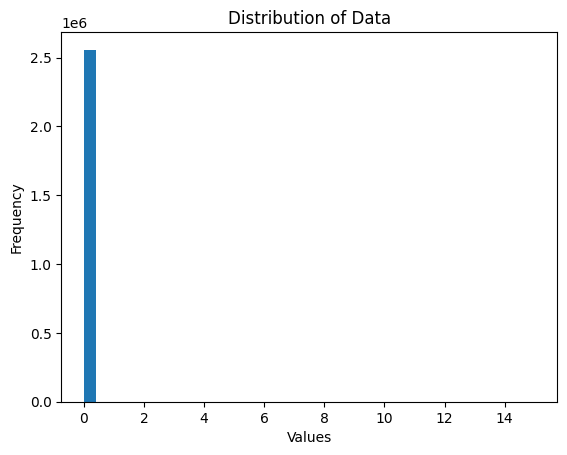

In [77]:
import matplotlib.pyplot as plt

# Example list of data
data = differences

# Plotting the histogram
plt.hist(data, bins=37)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Data')
plt.show()

In [91]:
len(differences)/((3196*3196)/2)

0.5006741452472662

In [92]:
len(differences) / ((X.shape[0]**2)/2)

0.5006741452472662

In [90]:
len(all)

5105610

In [88]:
(3196*3196)/2

5107208.0

In [27]:
Colon.make_change()

In [28]:
Colon.pherom

5

In [29]:
ant = Ant()
ant.multiple()
Colon.pherom

10